# Image recognition - Prediction of melanoma risk

Various differential diagnoses of pigmented skin lesions

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Pie_chart_of_incidence_and_malignancy_of_pigmented_skin_lesions.png/435px-Pie_chart_of_incidence_and_malignancy_of_pigmented_skin_lesions.png' />

Looking at the area in question is the most common method of suspecting a melanoma. 

**Moles that are irregular in color or shape are typically treated as candidates**

To detect melanomas (and increase survival rates), it is recommended to regularly examine moles for changes (shape, size, color, itching or bleeding) and to consult a qualified physician when a candidate appears.

Our project can help to do this examination.

Our CNN method for skin tumor classification has some limitations:

- the testing dataset was known and there is a risk of overfitting;

- the dataset is imbalanced and has less images for rare tumors;

- the dermatoscopic images were not standardized, having different camera angles, orientations, multiple skin backgrounds, and lighting.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [7]:
import os, zipfile

path = 'C:/CMD' #'/content/drive/MyDrive/temp'
file_name = "C:/CMD/archive.zip"

os.chdir(path) # change directory 

zip_ref = zipfile.ZipFile(file_name) # create zipfile object
zip_ref.extractall(path) # extract file to dir
zip_ref.close() # close file
os.remove(file_name) # delete zipped file

In [8]:
from numpy.random import seed
seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.config.list_physical_devices('GPU')

[]

In [10]:
main_path='C:/CMD' #'/content/drive/MyDrive/temp/'

In [11]:
os.listdir(main_path)

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [12]:
base_dir = main_path + '/base_dir'

# train_dir
train_dir = os.path.join(base_dir, 'train_dir2')

# val_dir
val_dir = os.path.join(base_dir, 'val_dir2')

# test_dir
test_dir = os.path.join(base_dir, 'test_dir2')

If not created, run this part below

In [13]:
# Create a new directory
base_dir = main_path + '/base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir2')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir2')
os.mkdir(val_dir)

# test_dir
val_dir = os.path.join(base_dir, 'test_dir2')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [54]:
df_data = pd.read_csv(main_path + '/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Create Train and Val Sets

In [25]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df[df['image_id'] == 1].reset_index(inplace=True)

df[df['image_id'] == 1].head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000001,1,1,1,1,1,1
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1
HAM_0000007,1,1,1,1,1,1
HAM_0000008,1,1,1,1,1,1


In [55]:
df_data = df_data.dropna()
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [34]:
# df_data['dx_'] = df['dx']
y = df_data['dx']

df_train, df_val_ = train_test_split(df_data, test_size=0.2, random_state=101, stratify=y)

df_train, df_test = train_test_split(df_train_, test_size=0.1, random_state=101, stratify=y)

df_val.shape, df_train.shape

((1992, 7), (7966, 7))

In [35]:
df_val.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
1379,HAM_0000417,ISIC_0025783,mel,histo,65.0,male,back
6482,HAM_0006008,ISIC_0028342,nv,follow_up,35.0,female,lower extremity
9216,HAM_0007543,ISIC_0024519,nv,consensus,55.0,female,lower extremity
4918,HAM_0000004,ISIC_0024645,nv,follow_up,40.0,female,back
9452,HAM_0005316,ISIC_0033907,nv,consensus,35.0,male,unknown


In [36]:
df_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
1973,HAM_0005064,ISIC_0028198,mel,histo,40.0,female,back
3065,HAM_0005407,ISIC_0028090,nv,follow_up,55.0,male,lower extremity
2253,HAM_0005909,ISIC_0026045,mel,histo,65.0,male,upper extremity
7118,HAM_0006516,ISIC_0033315,nv,histo,35.0,female,trunk
4215,HAM_0004602,ISIC_0031240,nv,follow_up,55.0,female,trunk


In [13]:
# # This set will be df_data excluding all rows that are in the val set

# # This function identifies if an image is part of the train
# # or val set.
# def identify_val_rows(x):
#     # create a list of all the lesion_id's in the val set
#     val_list = list(df_val['image_id'])
    
#     if str(x) in val_list:
#         return 'val'
#     else:
#         return 'train'

# # identify train and val rows

# # create a new colum that is a copy of the image_id column
# df_data['train_or_val'] = df_data['image_id']
# # apply the function to this new column
# df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# # filter out train rows
# df_train = df_data.loc[df_data['train_or_val'] == 'train']


# print(len(df_train))
# print(len(df_val))

4401
1101


In [50]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
train_list[:5], val_list[:5]

(['ISIC_0028198',
  'ISIC_0028090',
  'ISIC_0026045',
  'ISIC_0033315',
  'ISIC_0031240'],
 ['ISIC_0025783',
  'ISIC_0028342',
  'ISIC_0024519',
  'ISIC_0024645',
  'ISIC_0033907'])

In [56]:
df_info = df_data.set_index('image_id', inplace=False)
df_info.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [57]:
df_info.loc['ISIC_0033907','dx']

'nv'

## Transfer images to folders

In [58]:
# Get a list of images in each of the two folders
folder_1 = os.listdir(main_path + '/ham10000_images_part_1')
folder_2 = os.listdir(main_path + '/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


# Transfer the train images
for image in train_list:
    
    fname = image + '.jpg'
    label = df_info.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(main_path + '/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(main_path + '/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images
for image in val_list:
    
    fname = image + '.jpg'
    label = df_info.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(main_path + '/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(main_path + '/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [59]:
# 'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6
class_list = ['akiec','bcc','bkl','df','mel','nv', 'vasc']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = main_path + '/aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir(main_path + '/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join(main_path + '/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = main_path + '/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree(main_path + '/aug_dir')

Found 261 images belonging to 1 classes.
Found 411 images belonging to 1 classes.
Found 871 images belonging to 1 classes.
Found 92 images belonging to 1 classes.
Found 889 images belonging to 1 classes.
Found 5328 images belonging to 1 classes.
Found 114 images belonging to 1 classes.


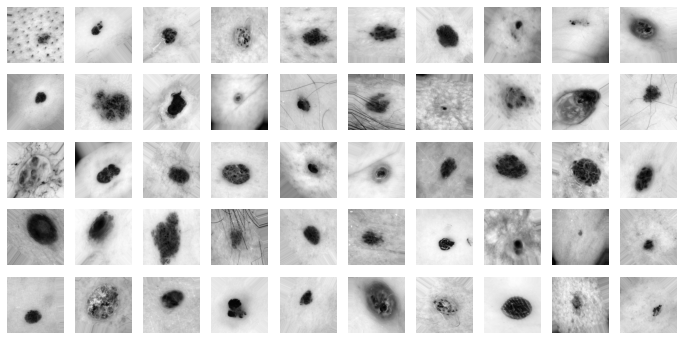

In [181]:
# plots images with labels

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
        
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        im=cv2.cvtColor(ims[i], cv2.COLOR_RGB2GRAY)
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(im, cmap='gray')
        
plots(imgs[0:], titles=None) # titles=labels will display the image labels

# Model

In [63]:
train_path = main_path + '/base_dir/train_dir'
valid_path = main_path + '/base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [64]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38881 images belonging to 7 classes.
Found 1992 images belonging to 7 classes.
Found 1992 images belonging to 7 classes.


In [65]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 5s 0us/step


In [66]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [67]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [68]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [70]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [72]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.2, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [73]:
filepath = main_path + "skin_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
797/797 [==============================] - 571s 710ms/step - loss: 2.5458 - categorical_accuracy: 0.2646 - top_2_accuracy: 0.4544 - top_3_accuracy: 0.5992 - val_loss: 1.6826 - val_categorical_accuracy: 0.5090 - val_top_2_accuracy: 0.6551 - val_top_3_accuracy: 0.7846

Epoch 00001: val_top_3_accuracy improved from -inf to 0.78464, saving model to /content/drive/MyDrive/temp\model.h5
Epoch 2/30
797/797 [==============================] - 562s 706ms/step - loss: 1.5759 - categorical_accuracy: 0.4126 - top_2_accuracy: 0.6157 - top_3_accuracy: 0.7622 - val_loss: 1.7879 - val_categorical_accuracy: 0.4458 - val_top_2_accuracy: 0.5617 - val_top_3_accuracy: 0.6973

Epoch 00002: val_top_3_accuracy did not improve from 0.78464
Epoch 3/30
797/797 [==============================] - 551s 691ms/step - loss: 1.4305 - categorical_accuracy: 0.4615 - top_2_accuracy: 0.6655 - top_3_accuracy: 0.8115 - val_loss: 1.0808 - val_categorical_accuracy: 0.6611 - val_top_2_accuracy: 0.7766 - val_top_3_accu


Epoch 00022: val_top_3_accuracy improved from 0.97390 to 0.97540, saving model to /content/drive/MyDrive/temp\model.h5
Epoch 23/30
797/797 [==============================] - 550s 690ms/step - loss: 0.5579 - categorical_accuracy: 0.7972 - top_2_accuracy: 0.9283 - top_3_accuracy: 0.9788 - val_loss: 0.5600 - val_categorical_accuracy: 0.7937 - val_top_2_accuracy: 0.9192 - val_top_3_accuracy: 0.9754

Epoch 00023: val_top_3_accuracy did not improve from 0.97540
Epoch 24/30
797/797 [==============================] - 550s 690ms/step - loss: 0.5762 - categorical_accuracy: 0.7876 - top_2_accuracy: 0.9319 - top_3_accuracy: 0.9818 - val_loss: 0.5573 - val_categorical_accuracy: 0.7871 - val_top_2_accuracy: 0.9217 - val_top_3_accuracy: 0.9739

Epoch 00024: val_top_3_accuracy did not improve from 0.97540

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 25/30
797/797 [==============================] - 550s 690ms/step - loss: 0.5546 - categorical_accuracy: 0.7938

In [74]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

1992/1992 [==============================] - 40s 20ms/step - loss: 0.5501 - categorical_accuracy: 0.7907 - top_2_accuracy: 0.9242 - top_3_accuracy: 0.9759
val_loss: 0.5501179695129395
val_cat_acc: 0.7906626462936401
val_top_2_acc: 0.9241967797279358
val_top_3_acc: 0.9759036302566528


In [76]:
# Here the best epoch will be used.

# model.load_weights('model.h5')

# val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
# model.evaluate(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.5501179695129395
val_cat_acc: 0.7906626462936401
val_top_2_acc: 0.9241967797279358
val_top_3_acc: 0.9759036302566528


# Loading of pretrained model

In [77]:
from tensorflow.keras.models import load_model

# model.save('skin_model.h5')
# del model  # deletes the existing model

# returns a compiled model
load_path = 'skin_model.h5
model = load_model(load_path, custom_objects={"top_2_accuracy": top_2_accuracy, "top_3_accuracy":top_3_accuracy})

# Prediction

In [82]:
!pip install opencv-python

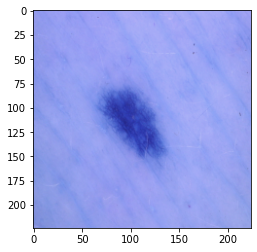

In [110]:
# Import cv2 (OpenCV library) and use cv2.resize to resize an input image(s) to 224 by 224 pixels.
import cv2

img1 = cv2.imread('C:/CMD/base_dir/val_dir/nv/ISIC_0029442.jpg', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('C:/CMD/base_dir/val_dir/mel/ISIC_0025439.jpg', cv2.IMREAD_UNCHANGED)
resized1 = cv2.resize(img1, (224, 224), interpolation = cv2.INTER_AREA)
resized2 = cv2.resize(img2, (224, 224), interpolation = cv2.INTER_AREA)

plt.imshow(resized1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)

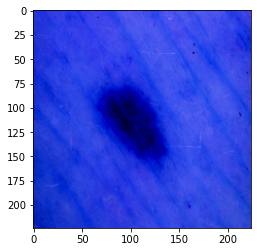

In [112]:
from tensorflow.keras.applications.mobilenet import preprocess_input

prep1 = preprocess_input(resized1)
prep2 = preprocess_input(resized2)
plt.imshow(prep1)
prep1.shape

In [118]:
input1 = prep1.reshape(1,224,224,3)
input2 = prep2.reshape(1,224,224,3)

In [94]:
model.input_shape

(None, 224, 224, 3)

In [95]:
# 7 types of skin lesions
class_names={
    0: 'akiec', # actinic keratoses and intraepithelial carcinoma/Bowen disease (akiec)
    1: 'bcc', # basal cell carcinoma (bcc)
    2: 'bkl', # benign lesions of the keratosis type (solar lentigine/seborrheic keratoses and lichen-planus like keratosis, bkl)
    3: 'df', # dermatofibroma (df)
    4: 'mel', # melanoma (mel)
    5: 'nv', # melanocytic nevi (nv)
    6: 'vasc' # vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhages, vasc)
}

In [126]:
pred_class = model.predict(input2)
pred_prob = (pred_class).argsort().ravel()[::-1]
pred_name_class = class_names[pred_class.argmax()].upper()
pred_M = 100*pred_class[:,4][0]

# print in red if the risk of melanoma is high
if pred_M > 5:
    f1,f2 = '\x1b[31m','\x1b[0m'
else:
    f1,f2 = '',''

print(f'Predicted class: {pred_name_class}, predicted risk: {f1}{pred_M:.8f}{f2}')

Predicted class: NV, predicted risk: 21.29513770


In [120]:
for i, pr in enumerate(pred_class[0]):
  print(f'Probability of type {class_names[i].upper()}: {100*pr:.8f}%')

Probability of type AKIEC: 0.00033296%
Probability of type BCC: 0.08115616%
Probability of type BKL: 1.64171513%
Probability of type DF: 0.01711996%
Probability of type MEL: 21.29513770%
Probability of type NV: 76.54876113%
Probability of type VASC: 0.41577541%


# The final function for our API

In [195]:
def predict_one(img, model=model, print_all=False, plot_img=False):
    resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    preprocessed = preprocess_input(resized)
    input_img = preprocessed.reshape(1,224,224,3)
    
    class_names={
    0: 'akiec', # actinic keratoses and intraepithelial carcinoma/Bowen disease (akiec)
    1: 'bcc', # basal cell carcinoma (bcc) *
    2: 'bkl', # benign lesions of the keratosis type (solar lentigine/seborrheic keratoses and lichen-planus like keratosis, bkl)
    3: 'df', # dermatofibroma (df)
    4: 'mel', # melanoma (mel) *
    5: 'nv', # melanocytic nevi (nv)
    6: 'vasc' # vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhages, vasc)
}
    pred_class = model.predict(input_img)
    pred_prob = (pred_class).argsort().ravel()[::-1]
    pred_name_class = class_names[pred_class.argmax()].upper()
    pred_R = 100 - (100*pred_class[:,5][0])

    # print in red if the risk of melanoma is high
    if pred_R > 5:
        f1,f2 = '\x1b[31m','\x1b[0m'
    else:
        f1,f2 = '',''

    print(f'Predicted class: {pred_name_class}, predicted risk: {f1}{pred_R:.8f}{f2}%')
    
    if print_all:
        print()
        for i, pr in enumerate(pred_class[0]):
          print(f'Probability of type {class_names[i].upper()}: {100*pr:.8f}%')
        
    if plot_img:
        img_gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plt.imshow(img_gray, cmap='gray')
        plt.axis('off')
        plt.title('Mole')
        plt.show()
        
    return (pred_name_class, pred_class, pred_R)

In [187]:
img1 = cv2.imread('C:/CMD/base_dir/val_dir/nv/ISIC_0029442.jpg', cv2.COLOR_BGR2RGB) # nevus
img2 = cv2.imread('C:/CMD/base_dir/val_dir/mel/ISIC_0025439.jpg', cv2.COLOR_BGR2RGB) # melanoma
img3 = cv2.imread('C:/CMD/base_dir/val_dir/bcc/ISIC_0025601.jpg', cv2.COLOR_BGR2RGB) # bcc

img4 = cv2.imread('C:/CMD/random/1.jpeg', cv2.COLOR_BGR2RGB) # random
img5 = cv2.imread('C:/CMD/random/2.jpg', cv2.COLOR_BGR2RGB) # random
img6 = cv2.imread('C:/CMD/random/3.jpg', cv2.COLOR_BGR2RGB) # random

In [188]:
img4.shape

(400, 615, 3)

Predicted class: NV, predicted risk: 6.21306896%

Probability of type AKIEC: 0.00043163%
Probability of type BCC: 0.04988473%
Probability of type BKL: 5.62243871%
Probability of type DF: 0.00257675%
Probability of type MEL: 0.52132825%
Probability of type NV: 93.78693104%
Probability of type VASC: 0.01640733%


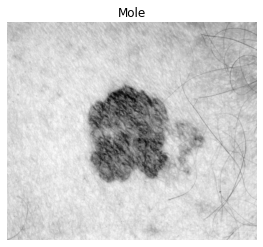

('NV',
 array([[4.3162722e-06, 4.9884734e-04, 5.6224387e-02, 2.5767482e-05,
         5.2132825e-03, 9.3786931e-01, 1.6407332e-04]], dtype=float32),
 6.213068962097168)

In [196]:
predict_one(img6, plot_img=True, print_all=True)